In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
#counting the number of players in each A/B group
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

## plotting the distribution of the number of game rounds players played during their first week playing the game

In [5]:
plot_df = df.groupby('sum_gamerounds').count().reset_index()
plot_df.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


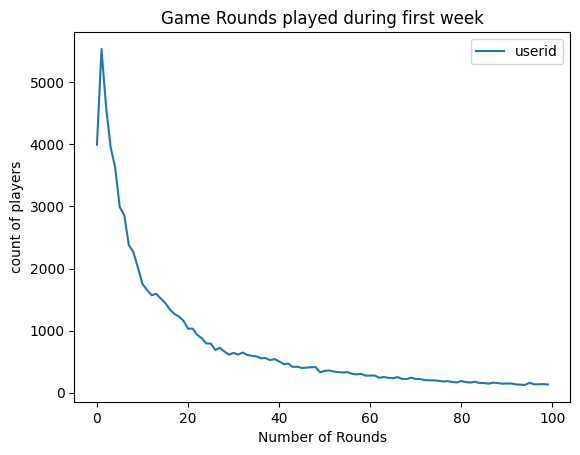

In [6]:
#counting the number of players for each number of game grounds
plot_df = df.groupby('sum_gamerounds').count().reset_index()

#plotting the distribution of players that played 0 t0 100 game rounds
ax = plot_df.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel('Number of Rounds')
ax.set_ylabel('count of players')
ax.set_title('Game Rounds played during first week');
%matplotlib inline

## 

In [7]:
#The % of players that continue playing after day-1 installing
df['retention_1'].mean()

0.4452095044850259

0.445 ie less than half of the players come back 1 day after installing the game

In [8]:
#calculating 1 day retention for each AB-group(gate_30 and gate_40)
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

There is a decrease in day-1 retention when the gate was moved from gate_30 (44.8% ) to gate_40 (44.2%)

To understand the uncertainty and variability in the mean estimates, Bootstrap method is used to estimate the distribution of the mean day-1 retention rates for each A/B group. We will re-sample our dataset(with replacement) and calculate day-1 retention for those samples.
This is crucial for making informed decisions in A/B testing.

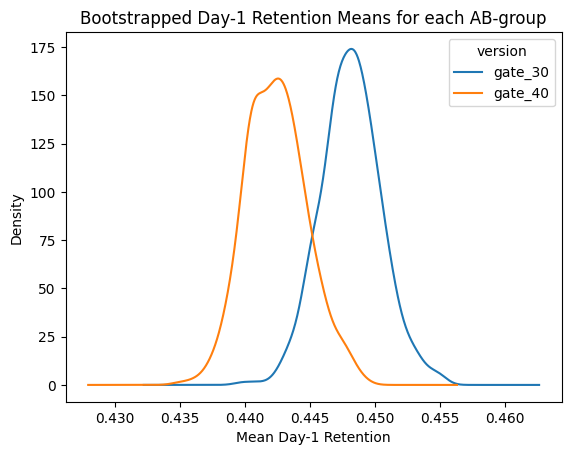

In [9]:
#creating a list with bootstrapped means for each AB-group
boot_d1 = []
iterations = 500  # No of bootstrap samples to generate

#bootstrap loop:
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    #takes a random samples from the df with replacement 
    boot_d1.append(boot_mean)
    
#Transforming the list to a Dataframe
boot_d1 = pd.DataFrame(boot_d1)

# kernel Density Estimate plot of the bootstrap distributions
ax = boot_d1.plot.kde()
ax.set_title('Bootstrapped Day-1 Retention Means for each AB-group')
ax.set_xlabel('Mean Day-1 Retention');

In [10]:
#checking first few rows of bootd1
boot_d1.head()

version,gate_30,gate_40
retention_1,0.445080,0.437131
retention_1,0.446617,0.439906
retention_1,0.446758,0.443295
retention_1,0.444081,0.440299
retention_1,0.449236,0.443686


Text(0.5, 1.0, 'Bootstrap % Difference in day-1 Rentention Means')

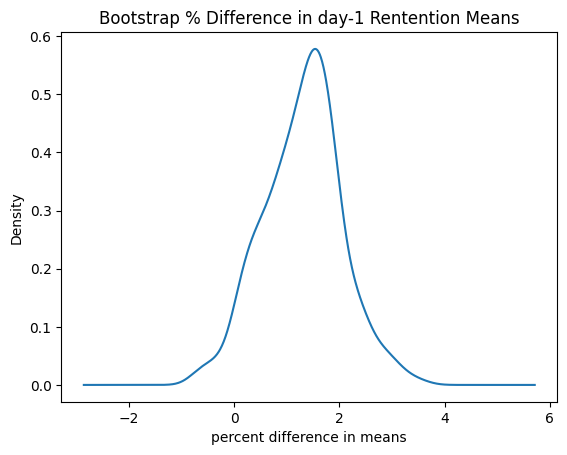

In [11]:
#Adding a column with the % difference b/w the two A/B-groups
boot_d1['diff'] = ((boot_d1.gate_30 - boot_d1.gate_40) / boot_d1.gate_40 * 100)

#plotting the bootstrap % difference
ax = boot_d1['diff'].plot.kde()
ax.set_xlabel('percent difference in means')
ax.set_title('Bootstrap % Difference in day-1 Rentention Means')

The chart show that the difference is around 1% - 2% and most distribution is above 0% in favour of gate_30.

In [12]:
#calculating the probability that day-1 retention is greater when the gate is at level 30
#prob = (boot_d1['diff'] > 0).sum() / len(boot_d1['diff'])
prob = (boot_d1['diff'] > 0).mean()

#printing
'{0:.1%}'.format(prob)

'96.2%'

The bootstrap Analysis is telling us that there is a high probability that the day-1 retention is better when the gate is at the level 30

In [13]:
#calculating the Day-7 retention for both AB-groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Just like the Day-1 retention, The Day-7 retention is lower(18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%).
Using Bootstrap to check difference

'99.8%'

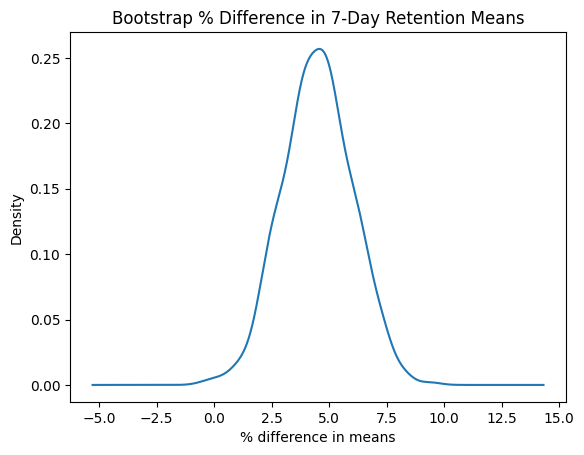

In [14]:
# Creating a list with bootstrapped means for each AB-group
boot_d7 = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_d7.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_d7 = pd.DataFrame(boot_d7)

# Adding a column with the % difference between the two AB-groups
boot_d7['diff'] = ((boot_d7['gate_30'] - boot_d7['gate_40']) / 
                   boot_d7['gate_40'] * 100)

# Ploting the bootstrap % difference
ax = boot_d7['diff'].plot.kde()
ax.set_xlabel("% difference in means")
ax.set_title('Bootstrap % Difference in 7-Day Retention Means');

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_d7['diff'] > 0).mean()

# printing the probability
'{0:.1%}'.format(prob)

## Conclusion

The analysis from the bootstrap method provides compelling evidence that the 7-day retention rates are superior when the in-game barrier is positioned at level 30, compared to level 40. To maintain optimal retention rates for both the first and seventh day, it’s advisable to keep the barrier at level 30 instead of relocating it to level 40.